In [30]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import GridSearchCV

We want ot know how well the random forest can predict NDVI.
This is a particular case of NDVI because displays desertification over a region. showing a decreasing trend.

##### Performance Measure Selection
**root mean square error (RMSE)**
The most common.
- Follows the assumption that the errors are not biased.
- Is highly affected by outliers.

mean absolute percentage error (MAPE) - Sensitivie to values near 0 (our case) X

mean absolute scaled error (MASE) X

In [3]:
df_average = pd.read_csv('../ndvi_data/average_ndvi.csv')
df_average['date'] = pd.to_datetime(df_average.date)
df_average = df_average.drop(columns=['Unnamed: 0'])

Time series plot.

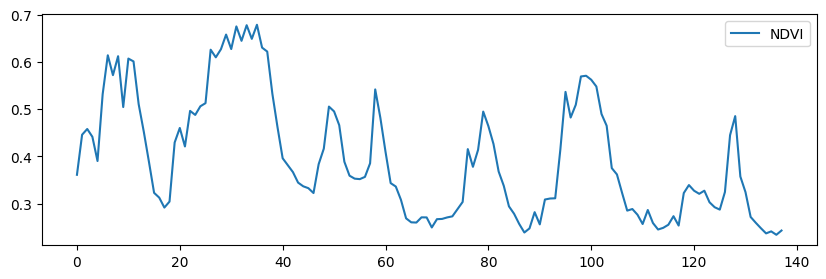

In [162]:
df_average.plot(figsize=(10,3), y='NDVI')
plt.show()

In [22]:

df_RF = df_average.copy()
df_RF ['Year'] = df_RF.date.dt.year
df_RF ['Month'] = df_RF.date.dt.month
df_RF = df_RF.dropna()

Correlation

In [6]:
def create_columns_shift(df,shift_number):
    df[f'{16*shift_number}DaysBefore'] = df.NDVI.shift(shift_number)

def drop_columns_shift(df, shift_number):
    df = df.drop(columns=[f'{16*shift_number}DaysBefore'], inplace=True)

In [23]:
#for i in range(1,22): create_columns_shift(df_RF,i) 
corr_matrix = df_RF.dropna().corr()
corr_matrix['NDVI'].sort_values(ascending=False)

NDVI     1.000000
Month   -0.333814
Year    -0.494871
date    -0.542570
Name: NDVI, dtype: float64

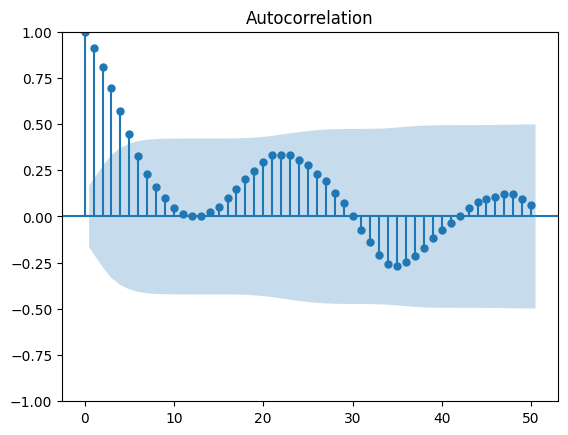

In [24]:
plot_acf(df_RF.NDVI, lags = 50)
plt.show()

We will use the first 4 lags, the month and the 

In [26]:
# Here we take the lags we want to use as features
for i in range(1,5): create_columns_shift(df_RF,i) 
df_RF.dropna(inplace=True)
df_RF.head()

,date,NDVI,Year,Month,16DaysBefore,32DaysBefore,48DaysBefore,64DaysBefore
8,2010-05-09,0.612157,2010,5,0.572040,0.614096,0.531723,0.390248
9,2010-05-25,0.504480,2010,5,0.612157,0.572040,0.614096,0.531723
10,2010-06-10,0.607084,2010,6,0.504480,0.612157,0.572040,0.614096
11,2010-06-26,0.601065,2010,6,0.607084,0.504480,0.612157,0.572040
12,2010-07-12,0.510580,2010,7,0.601065,0.607084,0.504480,0.612157


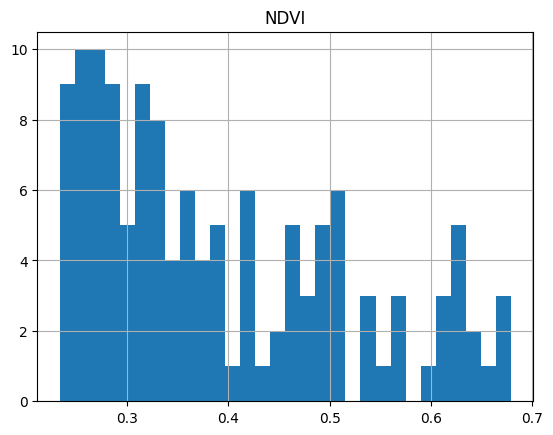

In [27]:
df_RF.hist('NDVI', bins=30)
plt.show()

In [28]:
df_RF.columns

Index(['date', 'NDVI', 'Year', 'Month', '16DaysBefore', '32DaysBefore',
       '48DaysBefore', '64DaysBefore'],
      dtype='object')

In [29]:
features_RF = list([np.array(df_RF[col]).reshape(-1,1) for col in [f'{i*16}DaysBefore' for i in range(1,5)]])
year = np.array(df_RF.Year).reshape(-1,1)
month = np.array(df_RF.Month).reshape(-1,1)
features_RF.append(year)
features_RF.append(month)
y = np.array(df_RF ['NDVI'])#.reshape(-1,1)
X = np.concatenate(features_RF, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Grid search for n_estimators

Here we a re going to calculate the range of the number of decision trees we will use in our model.

In [87]:
param_grid = [{'n_estimators':[1,2,5,8,10,15,20,40,60,80,90,100,120,150]}]
gid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid = param_grid, cv = 20, scoring='neg_root_mean_squared_error')
gid_search.fit(X_train,y_train)


GridSearchCV(cv=20, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'n_estimators': [1, 2, 5, 8, 10, 15, 20, 40, 60, 80,
                                           90, 100, 120, 150]}],
             scoring='neg_root_mean_squared_error')

In [88]:
search_results = pd.DataFrame(gid_search.cv_results_)
search_results['n_estimators'] = search_results['params'].apply(lambda x: x['n_estimators'])
search_results['mean_test_score'] = search_results['mean_test_score']*-1
search_results.sort_values(by='mean_test_score',ascending=True,inplace=True)
#print(search_results.columns)
print(search_results[['n_estimators','mean_test_score','std_test_score','rank_test_score']])

    n_estimators  mean_test_score  std_test_score  rank_test_score
10            90         0.042656        0.018365                1
9             80         0.042730        0.018195                2
11           100         0.042766        0.018199                3
13           150         0.043051        0.018370                4
12           120         0.043138        0.018306                5
7             40         0.043185        0.018534                6
8             60         0.043407        0.018470                7
6             20         0.043792        0.017861                8
5             15         0.044273        0.018290                9
2              5         0.044884        0.019465               10
4             10         0.045604        0.019965               11
3              8         0.046094        0.019179               12
1              2         0.049687        0.022432               13
0              1         0.059218        0.026602             

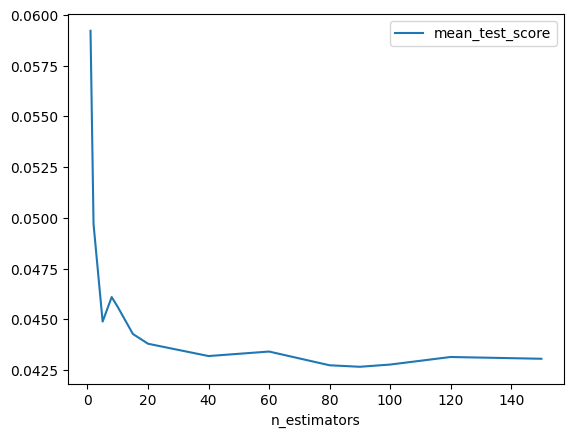

In [ ]:
search_results.sort_values(by='n_estimators').plot(x= 'n_estimators', y= 'mean_test_score', kind='line')
plt.show()


### Grid search for the number for the depth and number of desition trees

In [104]:
param_grid = [{'n_estimators':[1,5,10,15,20,40,60,80], 'max_depth':[2,3,4,5,6,7,8]}]
gid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid = param_grid, cv = 20, scoring='neg_root_mean_squared_error')
gid_search.fit(X_train,y_train)

GridSearchCV(cv=20, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 8],
                          'n_estimators': [1, 5, 10, 15, 20, 40, 60, 80]}],
             scoring='neg_root_mean_squared_error')

In [105]:
search_results = pd.DataFrame(gid_search.cv_results_)
search_results['n_estimators'],search_results['max_depth'] = search_results['params'].apply(lambda x: x['n_estimators']),search_results['params'].apply(lambda x: x['max_depth'])
search_results['mean_test_score'] = search_results['mean_test_score']*-1
print(search_results[['max_depth','n_estimators','mean_test_score','std_test_score','rank_test_score']])

    max_depth  n_estimators  mean_test_score  std_test_score  rank_test_score
0           2             1         0.056847        0.026324               52
1           2             5         0.050555        0.021846               49
2           2            10         0.049300        0.022727               46
3           2            15         0.050146        0.022202               47
4           2            20         0.050282        0.022581               48
5           2            40         0.049148        0.021939               44
6           2            60         0.049182        0.021625               45
7           2            80         0.048835        0.021386               43
8           3             1         0.055870        0.024768               50
9           3             5         0.045890        0.017923               41
10          3            10         0.045861        0.019569               40
11          3            15         0.045770        0.018944    

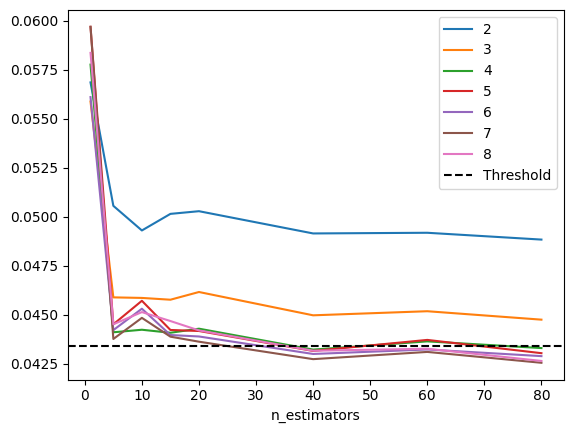

minimum number of trees 40


In [ ]:
fig, ax = plt.subplots(1,1)
for i_depth in search_results.max_depth.unique():
    search_results[search_results.max_depth == i_depth].sort_values(by='n_estimators').plot(x= 'n_estimators', y= 'mean_test_score', kind='line', label = i_depth, ax = ax)


max_test_score = search_results.mean_test_score.max()
min_test_score = search_results.mean_test_score.min()
threshold_test_score = min_test_score + (max_test_score - min_test_score)*0.05

plt.axhline(y = threshold_test_score, color = 'black', linestyle = 'dashed', label = 'Threshold')
plt.legend()
plt.show()


print('minimum number of trees -----',search_results[search_results.mean_test_score < threshold_test_score].n_estimators.min())
print('max depth ---- 4')

### Grid search by max_features
Maximum number of features that are evaluated for splitting at each node.

In [134]:
param_grid = [{'max_features':[1,2,3,4,5,6]}]
grid_search = GridSearchCV(RandomForestRegressor(n_estimators= 100, max_depth= 4, random_state= 42), param_grid = param_grid, cv = 20, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=20,
             estimator=RandomForestRegressor(max_depth=4, random_state=42),
             param_grid=[{'max_features': [1, 2, 3, 4, 5, 6]}],
             scoring='neg_root_mean_squared_error')

In [135]:
search_results = pd.DataFrame(grid_search.cv_results_)
search_results['max_features'] = search_results['params'].apply(lambda x: x['max_features'])
search_results['mean_test_score'] = search_results['mean_test_score']*-1
#print(search_results.columns)
print(search_results[['max_features','mean_test_score','std_test_score','rank_test_score']])

   max_features  mean_test_score  std_test_score  rank_test_score
0             1         0.053767        0.018245                6
1             2         0.047598        0.018239                5
2             3         0.044070        0.019174                4
3             4         0.043158        0.019794                1
4             5         0.043480        0.020012                3
5             6         0.043414        0.019133                2


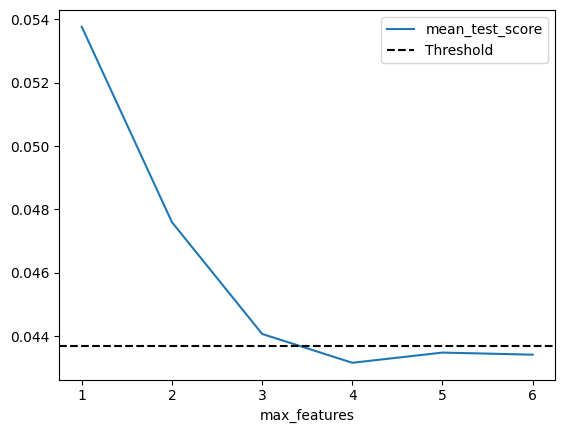

minimum number of features ----- 4


In [138]:
search_results.plot(x='max_features',y='mean_test_score')

max_test_score = search_results.mean_test_score.max()
min_test_score = search_results.mean_test_score.min()
threshold_test_score = min_test_score + (max_test_score - min_test_score)*0.05

plt.axhline(y = threshold_test_score, color = 'black', linestyle = 'dashed', label = 'Threshold')
plt.legend()
plt.show()


print('minimum number of features -----',search_results[search_results.mean_test_score < threshold_test_score].max_features.min())

plt.show()

## Final Model

In [141]:
model = RandomForestRegressor(n_estimators= 40, max_features= 4, max_depth=4, random_state= 42)
rmse_model = -cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=20)
print(pd.Series(rmse_model).describe())
model.fit(X_train,y_train)


count    20.000000
mean      0.043018
std       0.021501
min       0.015958
25%       0.026563
50%       0.042103
75%       0.054787
max       0.093918
dtype: float64


RandomForestRegressor(max_depth=4, max_features=4, n_estimators=40,
                      random_state=42)

Test of the model with the X_test

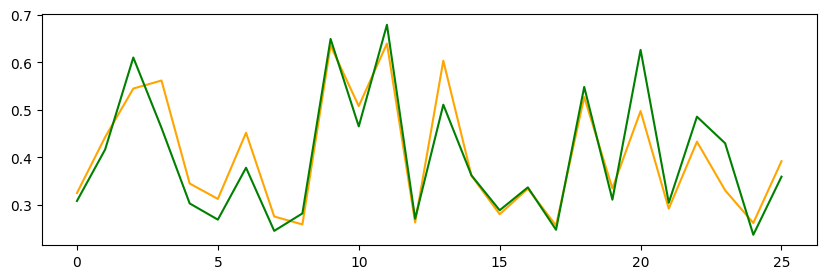

0.05186618770429946


In [ ]:
y_pred = model.predict(X_test)
plt.figure(figsize=(10,3))
plt.plot(y_pred, label = 'Predicted', c = 'orange')
plt.plot(y_test, label = 'Predicted', c = 'green')
plt.show()
print(root_mean_squared_error(y_pred,y_test))

In [ ]:
y_forecast = []

X_forcast = X[-1][:3]
X_forcast = np.append(y[-1],X_forcast)

for i,i_month in enumerate(df_RF[df_RF['Year'] == 2015].Month):
    X_forcast = np.append(X_forcast,np.array([2016,i_month]))
    new_y = model.predict([X_forcast])
    X_forcast = X_forcast[:3]
    X_forcast = np.append(new_y,X_forcast)

    y_forecast.append(new_y)

print(y_forecast)


[array([0.26243427]), array([0.268068]), array([0.2721232]), array([0.27109694]), array([0.27083229]), array([0.26700822]), array([0.26505116]), array([0.26505116]), array([0.26505116]), array([0.26505116]), array([0.26505116]), array([0.26505116]), array([0.26505116]), array([0.26505116]), array([0.26412889]), array([0.26412889]), array([0.26410852]), array([0.26410852]), array([0.26228351]), array([0.26228351]), array([0.26228351]), array([0.26228351]), array([0.26228351])]


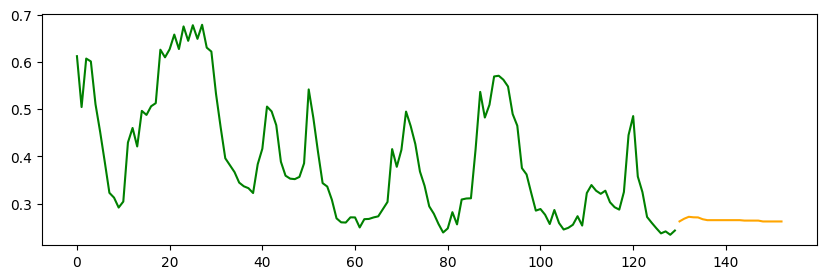

In [163]:
plt.figure(figsize=(10,3))
plt.plot(range(len(y),len(y)+len(y_forecast)), y_forecast, label = 'Predicted', c = 'orange')
plt.plot(y, label = 'Predicted', c = 'green')
plt.show()

In [ ]:
predicted_y = model.predict(X)
for i,i_month in enumerate(df_RF[df_RF['Year'] == 2015].Month):
    new_array = X[-1-i][:3]   # the last 16, 32, 48 which is going to be the 32, 48, and 64 of the next data
    new_array = np.append(new_array,np.array([2016,i_month])) #we add the year and the month
    new_array = np.append(predicted_y[-1],new_array) # this will be the previous 16-days data
    new_y = model.predict([new_array])
    predicted_y = np.append(predicted_y, new_y)
    print([new_y])

[array([0.27270257])]
[array([0.27232087])]
[array([0.26992268])]
[array([0.27372762])]
[array([0.29399269])]
[array([0.31400947])]
[array([0.33262289])]
[array([0.35212001])]
[array([0.35741362])]
[array([0.35440394])]
[array([0.37926686])]
[array([0.42360602])]
[array([0.4347955])]
[array([0.42486843])]
[array([0.39102584])]
[array([0.37917177])]
[array([0.33561135])]
[array([0.31116267])]
[array([0.29358933])]
[array([0.2672166])]
[array([0.27647779])]
[array([0.26221437])]
[array([0.25707557])]


For regularization we also have to compare the number of trees, the Max_feature and the depth.

Cross -validation
randomly splits the training set into _n_ nonoverlapping
subsets called folds, then it trains and evaluates the model _n_
times, picking a different fold for evaluation every time and using the other _n-1_
folds for training.

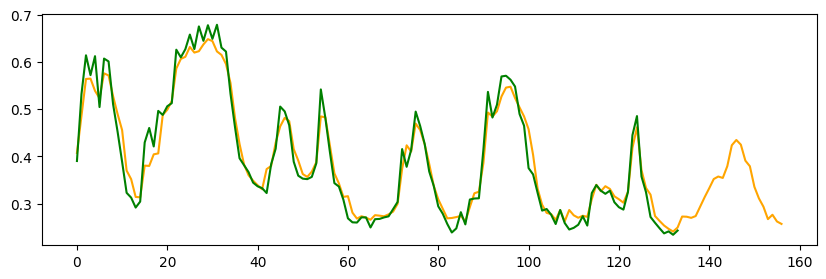

In [82]:
plt.figure(figsize=(10,3))
plt.plot(predicted_y, label = 'Predicted', c = 'orange')
plt.plot(y, label = 'Predicted', c = 'green')
plt.show()